<a href="https://colab.research.google.com/github/staocube88/AI-Model-Training/blob/master/AmywornV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Updated pip
!pip install --upgrade pip

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.3 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2


In [ ]:
#@title Installing All Required Libraries for the Fall Armyworm AI Detection Project
!pip install tensorflow keras tf2onnx onnx onnxruntime matplotlib scikit-learn opencv-python albumentations --quiet


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
tensorflow-metadata 1.17.2 requires protobuf>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.


In [8]:
#@title Library Imports and Environment Configuration
# Core
import os
import numpy as np
import matplotlib.pyplot as plt

# Data and image handling
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Deep learning (Keras / TensorFlow)
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Evaluation
from sklearn.metrics import classification_report, confusion_matrix

# Model conversion
import tf2onnx
import onnx
import onnxruntime as ort

# Data augmentation (optional)
import albumentations as A
from google.colab import drive


In [9]:
#@title Verifying Google Drive Mounted Successfully
drive.mount('/content/drive')
!ls /content/drive/MyDrive/

Mounted at /content/drive
'19 11-session2'
 2023_Annual_Report.gdoc
 20250128_165416.jpg
'21 11-session1'
'22 11-session1'
'4_6048361482406598276 (1).rtf.gdoc'
 4_6048361482406598276.rtf.gdoc
 70-347.pdf
'About my PC.gdoc'
'Abraham Great_VA Employment work_plan date .gsheet'
'Additional Documents.gdoc'
'Agenda 24 04 25.gdoc'
'Agenda 24 04 25.pdf'
'Amazon Gift Card.gdoc'
'Apache Kafka + Zilla.gdoc'
'Article: Secure Containerization: Hardening Kubernetes in DevOps Pipelines.gdoc'
'black founders'
'BUSINESS GAME PLAN(GRP 3).gdoc'
'Call For Audi,tions (Responses).gsheet'
 C++_files_handling.gdoc
'church workforce.gdoc'
"CIA 2019 MINISTER'S CONFERENCE REGISTRATION FORM.gform"
'CIA CMR Template_Centre Master.xlsx'
 CoinbaseWalletBackups
'Colab Notebooks'
 Complanet
'Contact Information.gform'
'Content for SaaS Website 1.docx'
'Content for SaaS Website 1.gdoc'
'Copy of  DISTINCT  GOOGLE DIGITAL SKILLS TRAINING KONVERGE.gform'
'Copy of Free Security Training Certificate Template.gdoc'
'Copy of

In [10]:
#@title Defining Dataset Paths and Verifying Class Folders
# Path to your dataset
DATA_DIR = '/content/drive/MyDrive/FAW_Dataset'

TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')

print("Train classes:", os.listdir(TRAIN_DIR))
print("Test classes:", os.listdir(TEST_DIR))


Train classes: ['healthy_crops', 'FAW_larva', 'FAW_damage']
Test classes: ['healthy_crops', 'FAW_larva', 'FAW_damage']


In [11]:
#@title Image Preprocessing and Data Augmentation
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Training data generator (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # we'll create a validation split from the training set
)

# Validation split from the train folder
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Test data generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 2114 images belonging to 3 classes.
Found 527 images belonging to 3 classes.
Found 802 images belonging to 3 classes.


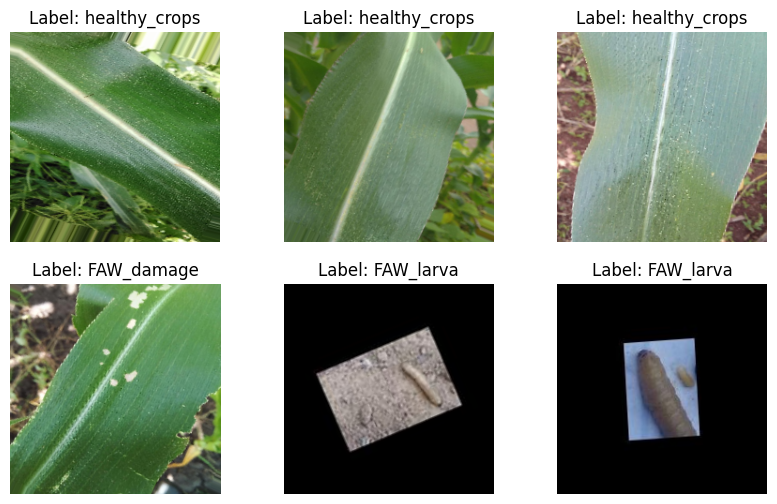

In [12]:
#@title Visualizing Sample Images from the Training Dataset
# import matplotlib.pyplot as plt
# import numpy as np

x_batch, y_batch = next(train_generator)

plt.figure(figsize=(10, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(x_batch[i])
    plt.title(f"Label: {list(train_generator.class_indices.keys())[np.argmax(y_batch[i])]}")
    plt.axis('off')
plt.show()


In [13]:
#@title Building the Deep Learning Model Using MobileNetV2 (Transfer Learning)

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Number of output classes (update if yours differ)
num_classes = len(train_generator.class_indices)

# Load base model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers (so we only train the top layers)
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification head
x = GlobalAveragePooling2D()(base_model.output)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,261,827 (8.63 MB)

 Trainable params: 3,843 (15.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [14]:
#@title Model Training with Early Stopping and Checkpointing
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Callbacks
early_stop = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_faw_model.keras', monitor='val_accuracy', save_best_only=True)

# Train
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,  # increase to 15–20 if you have more compute
    callbacks=[early_stop, checkpoint]
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 702s 10s/step - accuracy: 0.7689 - loss: 0.5468 - val_accuracy: 0.9336 - val_loss: 0.1860
Epoch 2/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9664 - loss: 0.1225 - val_accuracy: 0.9620 - val_loss: 0.1474
Epoch 3/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9674 - loss: 0.0924 - val_accuracy: 0.9488 - val_loss: 0.1204
Epoch 4/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9754 - loss: 0.0712 - val_accuracy: 0.9658 - val_loss: 0.0974
Epoch 5/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9892 - loss: 0.0485 - val_accuracy: 0.9715 - val_loss: 0.0840
Epoch 6/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.9823 - loss: 0.0566 - val_accuracy: 0.9886 - val_loss: 0.0543
Epoch 7/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9916 - loss: 0.0370 - val_accuracy: 0.9829 - val_loss: 0.0610
Epoch 8/10
67/67 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.9916 - loss: 0.0393 - val_accuracy: 0.9734 - 

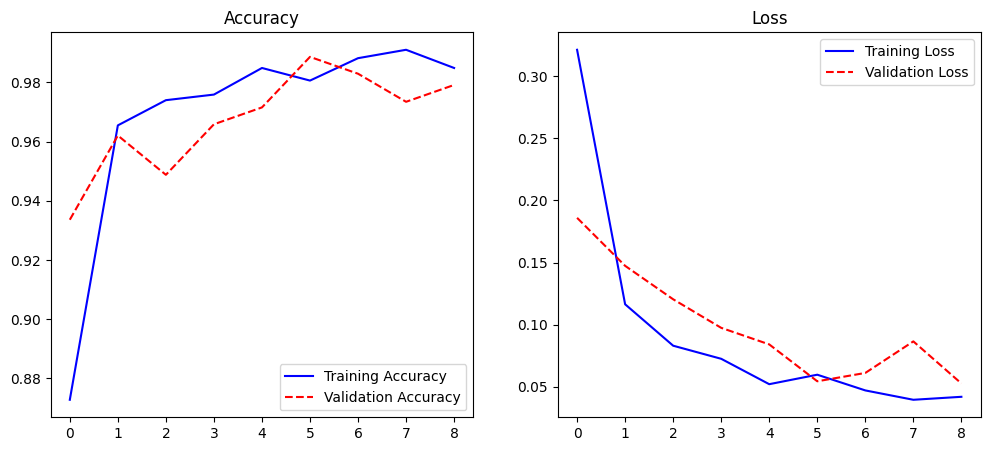

In [15]:
#@title Visualizing Model Training Performance
# import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
plt.legend()
plt.title('Loss')

plt.show()


In [16]:
#@title Model Evaluation on Test Data
test_loss, test_acc = model.evaluate(test_generator)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")

26/26 ━━━━━━━━━━━━━━━━━━━━ 224s 9s/step - accuracy: 0.9828 - loss: 0.0575
✅ Test Accuracy: 96.51%


26/26 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step
               precision    recall  f1-score   support

   FAW_damage       0.87      0.98      0.92       171
    FAW_larva       0.99      0.99      0.99       530
healthy_crops       1.00      0.81      0.90       101

     accuracy                           0.97       802
    macro avg       0.96      0.93      0.94       802
 weighted avg       0.97      0.97      0.96       802



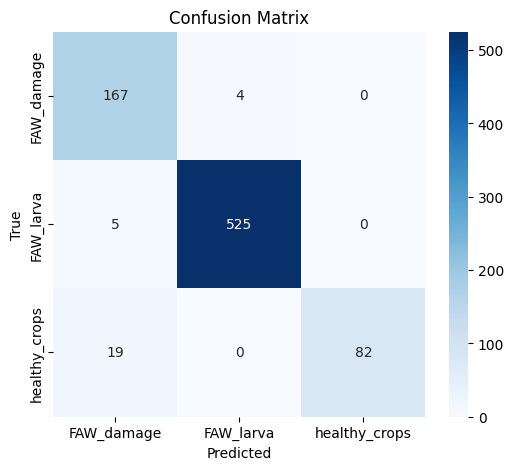

In [17]:
#@title Model Performance Evaluation Using Classification Report and Confusion Matrix
# from sklearn.metrics import classification_report, confusion_matrix
# import numpy as np

# Predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Report
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

# Confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [18]:
#@title Model Export to ONNX Format
# !pip install tf2onnx onnx onnxruntime --quiet

# import tf2onnx
# import tensorflow as tf

spec = (tf.TensorSpec((None, 224, 224, 3), tf.float32, name="input"),)
output_path = "faw_model.onnx"

# Convert to ONNX
model_proto, _ = tf2onnx.convert.from_keras(model, input_signature=spec, output_path=output_path)

print("✅ Model successfully exported to ONNX format!")

ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7ee881bda7a0>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


✅ Model successfully exported to ONNX format!


In [20]:
#@title Loading the Exported ONNX Model for Inference
# Purpose
# Path to your exported ONNX model
onnx_model_path = "/content/faw_model.onnx"

# Create ONNX runtime session
session = ort.InferenceSession(onnx_model_path)

Saving 691.jpg to 691.jpg


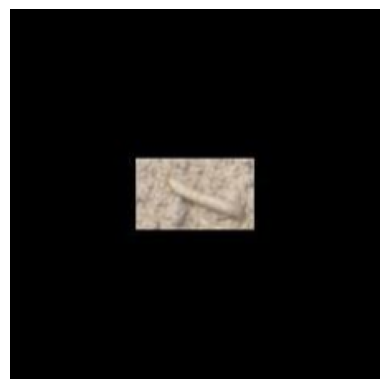

Predicted class: healthy (Confidence: 99.95%)


In [22]:
#@title Uploading and Running Inference on a Single Image using the ONNX Model
# ✅ Upload image
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
    img_path = fn

    # Load and preprocess image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (224, 224))
    img_norm = img_resized.astype(np.float32) / 255.0
    img_input = np.expand_dims(img_norm, axis=0)  # ✅ (1, 224, 224, 3)

    # Run inference
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    preds = session.run([output_name], {input_name: img_input})[0]

    predicted_class = np.argmax(preds, axis=1)[0]
    confidence = np.max(preds)

    # Show image
    plt.imshow(img_resized)
    plt.axis("off")
    plt.show()

    # Map class index to label
    class_names = ['damage', 'healthy', 'larva']  # adjust to your dataset
    print(f"Predicted class: {class_names[predicted_class]} (Confidence: {confidence*100:.2f}%)")

In [23]:
#@title Building an Interactive Web Interface for Fall Armyworm Detection Using Gradio

!pip install gradio

import gradio as gr
import onnxruntime as ort
import numpy as np
import cv2

session = ort.InferenceSession("/content/faw_model.onnx")
class_names = ['damage', 'healthy', 'larva']  # match your correct order

def predict_image(img):
    img = cv2.resize(img, (224, 224))
    img_norm = img.astype(np.float32) / 255.0
    img_input = np.expand_dims(img_norm, axis=0)
    preds = session.run([session.get_outputs()[0].name],
                        {session.get_inputs()[0].name: img_input})[0]
    pred_class = np.argmax(preds, axis=1)[0]
    conf = np.max(preds)
    return {class_names[pred_class]: float(conf)}

gr.Interface(
    fn=predict_image,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=3),
    title="Fall Armyworm Classifier"
).launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ed8bc8e71332034039.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
